# 1. Setup

In [1]:
import os
import yaml

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

In [2]:
with open('config.yaml', 'r') as file:
    config = yaml.load(file, Loader=yaml.FullLoader)
print(config)

{'data': {'dir': 'Data/Detection-Big', 'height': 320, 'width': 320, 'channels': 3, 'geometry_scale_factor': 64}, 'model': {'name': 'EAST', 'geometry': 'AABB', 'with_classification': False}, 'training': {'info': '', 'batch_size': 32, 'score_weights_auto': True, 'score_weights_woc': [1, 10], 'score_weights_wc': [1, 10, 10, 10, 10], 'lambda_score': 1, 'lambda_geometry': 1, 'lr': 0.001, 'lr_step_size': 5, 'lr_gamma': 0.5, 'weight_decay': 0.001, 'num_epochs': 30}, 'prediction': {'model_path': 'Models/EAST-Detector-e21.pth', 'device': 'cuda', 'batch_size': 4, 'score_threshold': 0.8, 'iou_threshold': 0.1}, 'evaluation': {'predictions_dir_name': 'Annotations-AABB-Pred-EAST-0.8-0.1', 'iou_threshold': 0.75}}


In [3]:
train_dir = os.path.join(config['data']['dir'], 'Train')
val_dir = os.path.join(config['data']['dir'], 'Val')
test_dir = os.path.join(config['data']['dir'], 'Test')
print(train_dir, val_dir, test_dir)

Data/Detection-Big/Train Data/Detection-Big/Val Data/Detection-Big/Test


In [4]:
image_height = config['data']['height']
image_width = config['data']['width']

In [5]:
actuals_dir_name = 'Annotations-AABB'
predictions_dir_name = config['evaluation']['predictions_dir_name']
iou_threshold = config['evaluation']['iou_threshold']
print(actuals_dir_name, predictions_dir_name, iou_threshold)

Annotations-AABB Annotations-AABB-Pred-EAST-0.8-0.1 0.75


# 2. Define utils

In [6]:
def compute_iou(bb1, bb2):
    """
    bb1 : list of 4 values
        x1, y1, x2, y2
    bb2 : list of 4 values
        x1, y1, x2, y2
        
    Code Reference : https://stackoverflow.com/a/42874377  
    """
    
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[1], bb2[1])
    x_right = min(bb1[2], bb2[2])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[2] - bb1[0]) * (bb1[3] - bb1[1])
    bb2_area = (bb2[2] - bb2[0]) * (bb2[3] - bb2[1])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    
    return iou

In [7]:
def compute_metrics(actual_boxes, prediction_boxes, iou_threshold):
    """
    actual_boxes : np.array of shape(m, 4)
        An array of x1, y1, x2 and y2 for all boxes
    prediction_boxes : np.array of shape(n, 4)
        An array of x1, y1, x2 and y2 for all boxes
    """
    
    tp, fn, fp = 0, 0, 0
    # TODO: sort boxes
    actual_boxes = actual_boxes.tolist()
    prediction_boxes = prediction_boxes.tolist()
    
    for i in range(len(actual_boxes)):
        for j in range(len(prediction_boxes)):
            iou = compute_iou(actual_boxes[i], prediction_boxes[j])
            if iou >= iou_threshold:
                tp += 1
                del prediction_boxes[j]
                break
        else:
            fn += 1
    fp = len(prediction_boxes)
    
    return tp, fn, fp

In [8]:
def compute_performance_df(split='Test', iou_threshold=0.8):
    
    data_dir = os.path.join(config['data']['dir'], split)
    actuals_dir = os.path.join(data_dir, actuals_dir_name)
    predictions_dir = os.path.join(data_dir, predictions_dir_name)
    performance_df = [] 
    columns = ['name', 'num_actuals', 'num_predictions', 'tp', 'fn', 'fp']
    
    for file_name in tqdm(os.listdir(predictions_dir)):
        actual_fp = os.path.join(actuals_dir, file_name)
        prediction_fp = os.path.join(predictions_dir, file_name)
        actual_df = pd.read_csv(actual_fp)
        prediction_df = pd.read_csv(prediction_fp)
        actual_df['x2'] = actual_df['x'] + actual_df['w']
        actual_df['y2'] = actual_df['y'] + actual_df['h']
        prediction_df['x2'] = prediction_df['x'] + prediction_df['w']
        prediction_df['y2'] = prediction_df['y'] + prediction_df['h']
        
        actual_boxes = actual_df[['x', 'y', 'x2', 'y2']].values
        prediction_boxes = prediction_df[['x', 'y', 'x2', 'y2']].values
        num_actuals = len(actual_boxes)
        num_predictions = len(prediction_boxes)
        tp, fn, fp = compute_metrics(actual_boxes, prediction_boxes, iou_threshold=iou_threshold)
        row = [file_name.split(".")[0], num_actuals, num_predictions, tp, fn, fp]
        performance_df.append(row)
        
    performance_df = pd.DataFrame(performance_df, columns=columns)
    performance_df['precision'] = performance_df['tp'] / (performance_df['tp'] + performance_df['fp'])
    performance_df['recall'] = performance_df['tp'] / (performance_df['tp'] + performance_df['fn'])
    numerator = 2 * performance_df['precision'] * performance_df['recall']
    denominator = performance_df['precision'] + performance_df['recall']
    performance_df['f1_score'] = numerator / denominator 
    
    return performance_df

# 3. Evaluate

In [14]:
performance_df_train = compute_performance_df(split='Train', iou_threshold=iou_threshold)
print(performance_df_train.shape)

performance_df_val = compute_performance_df(split='Val', iou_threshold=iou_threshold)
print(performance_df_val.shape)

performance_df_test = compute_performance_df(split='Test', iou_threshold=iou_threshold)
print(performance_df_test.shape)
performance_df_test.head()


(50000, 9)



(1000, 9)



(1000, 9)


,name,num_actuals,num_predictions,tp,fn,fp,precision,recall,f1_score
0,Malayalam_23_819,2,2,1,1,1,0.500000,0.5,0.500000
1,Hindi_24_2678,1,2,0,1,2,0.000000,0.0,NaN
2,Punjabi_24_2003,5,7,1,4,6,0.142857,0.2,0.166667
3,Malayalam_24_2526,4,5,0,4,5,0.000000,0.0,NaN
4,Tamil_24_2764,5,5,2,3,3,0.400000,0.4,0.400000


In [15]:
performance_df_train.describe()

,num_actuals,num_predictions,tp,fn,fp,precision,recall,f1_score
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,49845.000000,50000.000000,38360.000000
mean,4.820680,5.173960,1.880520,2.94016,3.29344,0.354958,0.383488,0.468521
std,2.821823,2.784316,1.762313,2.15477,2.19274,0.280877,0.303171,0.224728
min,1.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.060606
25%,3.000000,3.000000,1.000000,1.00000,2.00000,0.125000,0.142857,0.285714
50%,4.000000,5.000000,1.000000,3.00000,3.00000,0.333333,0.333333,0.444444
75%,6.000000,7.000000,3.000000,4.00000,4.00000,0.500000,0.600000,0.615385
max,28.000000,27.000000,15.000000,21.00000,23.00000,1.000000,1.000000,1.000000


In [16]:
performance_df_val.describe()

,num_actuals,num_predictions,tp,fn,fp,precision,recall,f1_score
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,780.000000
mean,4.431000,5.26000,1.882000,2.549000,3.378000,0.339768,0.416210,0.465129
std,2.637839,2.75935,1.763856,1.951771,2.083616,0.265083,0.314957,0.218336
min,1.000000,1.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.086957
25%,3.000000,3.00000,1.000000,1.000000,2.000000,0.125000,0.166667,0.285714
50%,4.000000,5.00000,1.000000,2.000000,3.000000,0.333333,0.400000,0.444444
75%,6.000000,7.00000,3.000000,3.000000,5.000000,0.500000,0.666667,0.600000
max,17.000000,18.00000,12.000000,11.000000,13.000000,1.000000,1.000000,1.000000


In [10]:
performance_df_test.describe()

,num_actuals,num_predictions,tp,fn,fp,precision,recall,f1_score
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000,999.000000,1000.000000,767.000000
mean,4.640000,6.041000,1.774000,2.866000,4.26700,0.295901,0.375142,0.416881
std,2.646394,3.025305,1.606706,2.050426,2.60893,0.246024,0.296456,0.206832
min,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.086957
25%,3.000000,4.000000,1.000000,1.000000,2.00000,0.100000,0.125000,0.250000
50%,4.000000,6.000000,1.000000,2.000000,4.00000,0.250000,0.333333,0.400000
75%,6.000000,8.000000,3.000000,4.000000,6.00000,0.444444,0.571429,0.545455
max,18.000000,20.000000,11.000000,14.000000,18.00000,1.000000,1.000000,1.000000


In [11]:
performance_df_test[performance_df_test['tp']>0].head()

,name,num_actuals,num_predictions,tp,fn,fp,precision,recall,f1_score
0,Malayalam_23_819,2,2,1,1,1,0.500000,0.500000,0.500000
2,Punjabi_24_2003,5,7,1,4,6,0.142857,0.200000,0.166667
4,Tamil_24_2764,5,5,2,3,3,0.400000,0.400000,0.400000
5,Malayalam_24_2475,3,5,2,1,3,0.400000,0.666667,0.500000
6,Hindi_24_539,6,8,2,4,6,0.250000,0.333333,0.285714


# 4. Visualize detections

In [17]:
def visualize_detections(performance_df, predictions_dir, num_samples=10):
    data_dir = '/'.join(predictions_dir.split('/')[:-1])
    image_dir = os.path.join(data_dir, 'Images')
    actuals_dir = os.path.join(data_dir, 'Annotations-AABB')
    # TODO: Filter performance_df
    performance_df = performance_df.sample(n=num_samples)
    for row_id, row in performance_df.iterrows():
        
        image_fn = f'{row["name"]}.jpg'
        image_fp = os.path.join(image_dir, image_fn)
        image = cv2.imread(image_fp)
        image_actual, image_prediction = image.copy(), image.copy()
        
        ann_fn = f'{row["name"]}.csv'
        ann_fp_actual = os.path.join(actuals_dir, ann_fn)
        ann_df_actual = pd.read_csv(ann_fp_actual)
        for x, y, w, h in ann_df_actual.values:
            cv2.rectangle(image_actual, (x, y), (x+w, y+h), (255,0,0), 2)
            
        ann_fp_prediction = os.path.join(predictions_dir, ann_fn)
        ann_df_prediction = pd.read_csv(ann_fp_prediction)
        for x, y, w, h in ann_df_prediction.values:
            cv2.rectangle(image_prediction, (x, y), (x+w, y+h), (255,0,0), 2)
            
        info = f'TP:{row["tp"]};  FN:{row["fn"]}; FP:{row["fp"]}; Precision:{row["precision"]}; Recall:{row["recall"]}'
        print(info)
        fig, axes = plt.subplots(1, 2, figsize=(64//8, 32//8))
        axes[0].imshow(image_actual)
        axes[1].imshow(image_prediction)
        plt.show()      

TP:4;  FN:2; FP:4; Precision:0.5; Recall:0.6666666666666666


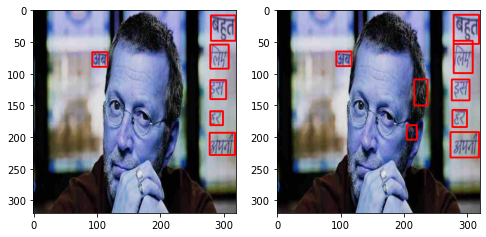

TP:1;  FN:2; FP:4; Precision:0.2; Recall:0.3333333333333333


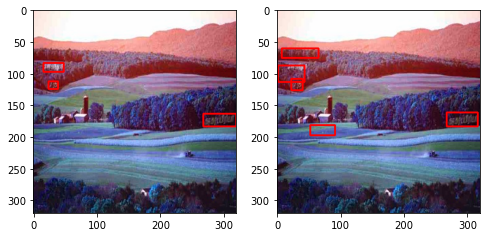

TP:1;  FN:2; FP:1; Precision:0.5; Recall:0.3333333333333333


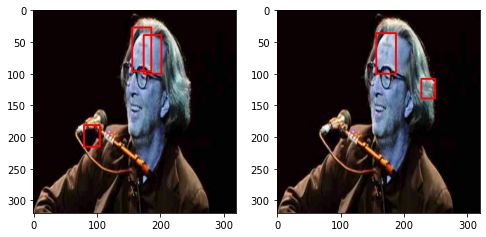

TP:3;  FN:1; FP:3; Precision:0.5; Recall:0.75


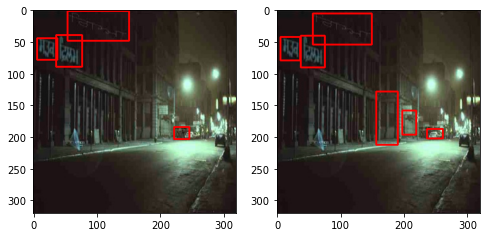

TP:4;  FN:2; FP:3; Precision:0.5714285714285714; Recall:0.6666666666666666


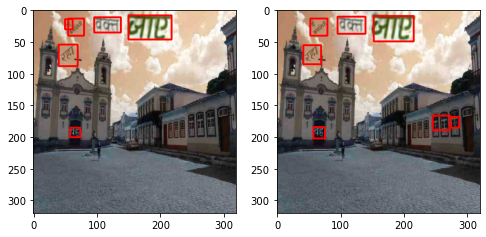

TP:3;  FN:1; FP:3; Precision:0.5; Recall:0.75


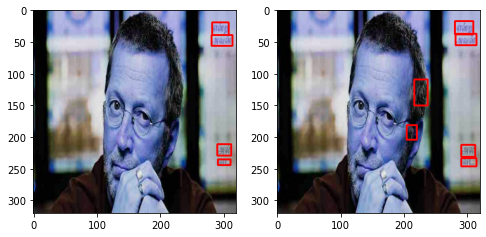

TP:3;  FN:5; FP:8; Precision:0.2727272727272727; Recall:0.375


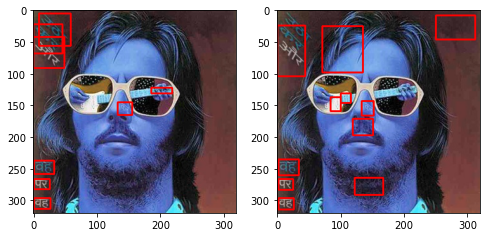

TP:2;  FN:3; FP:8; Precision:0.2; Recall:0.4


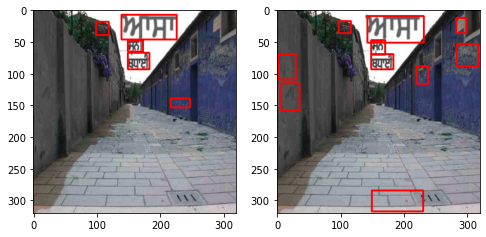

TP:0;  FN:5; FP:4; Precision:0.0; Recall:0.0


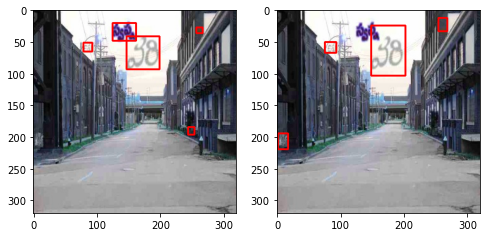

TP:0;  FN:6; FP:8; Precision:0.0; Recall:0.0


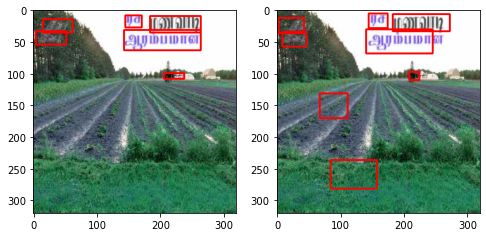

In [18]:
split = 'Test'
data_dir = os.path.join(config['data']['dir'], split)
predictions_dir = os.path.join(data_dir, predictions_dir_name)
visualize_detections(performance_df_test, predictions_dir, num_samples=10)